In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Set Up SDK

In [2]:
!pip uninstall -qqy jupyterlab kfp  # Remove unused conflicting packages
!pip install -U -q "google-genai==1.7.0"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.7/144.7 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.9/100.9 kB 4.9 MB/s eta 0:00:00


In [8]:
from google import genai
from google.genai import types
import google.generativeai as genai
from google.generativeai import embedding, configure

genai.__version__

'0.8.3'

### Set up your API key
This API Key is generated from Google AI Studio
https://aistudio.google.com/app/apikey?_gl=1*1uw0lp7*_ga*MTMzNDMzNzIzMi4xNzQzNDc1NTQ4*_ga_P1DBVKWT6V*MTc0MzQ3NTU0OC4xLjEuMTc0MzQ3NTU3Ny4zMS4wLjQzMjgwNjQxOQ..


In [12]:
from kaggle_secrets import UserSecretsClient

GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
configure(api_key=GOOGLE_API_KEY)

### Calculate similarity scores¶
This example embeds some variations on the pangram, The quick brown fox jumps over the lazy dog, including spelling mistakes and shortenings of the phrase. Another pangram and a somewhat unrelated phrase have been included for comparison.

In this task, I am going to use the embeddings to calculate similarity scores, so the task_type for these embeddings is semantic_similarity. 

A similarity score of two embedding vectors can be obtained by calculating their inner product. If  
u is the first embedding vector, and v the second, this is uTv. 
**As the API provides embedding vectors that are normalised to unit length, this is also the cosine similarity.**

This score can be computed across all embeddings through the matrix self-multiplication: df @ df.T.

Note that the range from 0.0 (completely dissimilar) to 1.0 (completely similar) is depicted in the heatmap from light (0.0) to dark (1.0).

In [13]:
texts = [
    'The quick brown fox jumps over the lazy dog.',
    'The quick rbown fox jumps over the lazy dog.',
    'teh fast fox jumps over the slow woofer.',
    'a quick brown fox jmps over lazy dog.',
    'brown fox jumping over dog',
    'fox > dog',
    # Alternative pangram for comparison:
    'The five boxing wizards jump quickly.',
    # Unrelated text, also for comparison:
    'Lorem ipsum dolor sit amet, consectetur adipiscing elit. Vivamus et hendrerit massa. Sed pulvinar, nisi a lobortis sagittis, neque risus gravida dolor, in porta dui odio vel purus.',
]


model = genai.GenerativeModel(model_name="gemini-2.0-flash-thinking-exp-1219")

# Gemini embedding model expects one string at a time
embeddings = []
for text in texts:
    response = embedding.embed_content(
        model="models/embedding-001",
        content=text,
        task_type="semantic_similarity"
    )
    embeddings.append(response["embedding"])

# Check length of vectors
print("Each embedding is a vector of length:", len(embeddings[0]))

Each embedding is a vector of length: 768


In [14]:
def truncate(t: str, limit: int = 50) -> str:
  """Truncate labels to fit on the chart."""
  if len(t) > limit:
    return t[:limit-3] + '...'
  else:
    return t

truncated_texts = [truncate(t) for t in texts]

### Draw Heatmap using embeddings dataframe

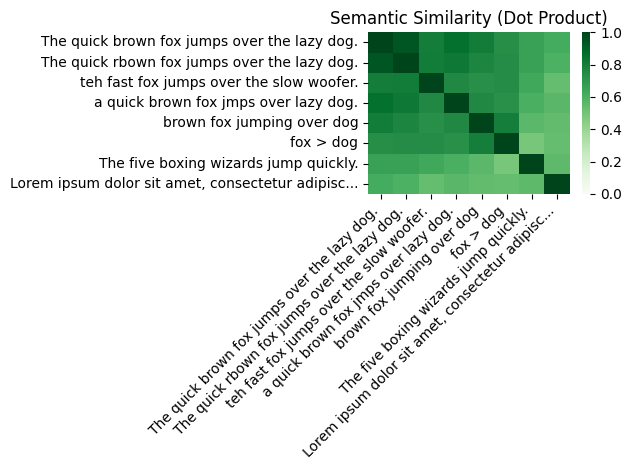

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Set up the embeddings in a dataframe.
df = pd.DataFrame(embeddings, index=truncated_texts)

# Perform the similarity calculation
sim = df @ df.T
# Draw!
sns.heatmap(sim, vmin=0, vmax=1, cmap="Greens");
plt.title("Semantic Similarity (Dot Product)")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### You now get a true cosine similarity matrix between all documents. Close-to-1 means "very similar", close-to-0 means "very different".

### Highlight Top Similar Pairs (excluding self-similarity)

In [23]:
import numpy as np

# Copy similarity matrix, mask self-similarity
sim_no_diag = sim.copy()
np.fill_diagonal(sim_no_diag.values, 0)

# Flatten and get top 5 most similar pairs
top_similar = (
    sim_no_diag.stack()
    .sort_values(ascending=False)
    .reset_index()
    .rename(columns={'level_0': 'Text A', 'level_1': 'Text B', 0: 'Cosine Similarity'})
)

print("🔍 Top 5 Most Similar Text Pairs:\n")
print(top_similar.head(5))


🔍 Top 5 Most Similar Text Pairs:

                                         Text A  \
0  The quick rbown fox jumps over the lazy dog.   
1  The quick brown fox jumps over the lazy dog.   
2         a quick brown fox jmps over lazy dog.   
3  The quick brown fox jumps over the lazy dog.   
4         a quick brown fox jmps over lazy dog.   

                                         Text B  Cosine Similarity  
0  The quick brown fox jumps over the lazy dog.           0.944768  
1  The quick rbown fox jumps over the lazy dog.           0.944768  
2  The quick brown fox jumps over the lazy dog.           0.858135  
3         a quick brown fox jmps over lazy dog.           0.858135  
4  The quick rbown fox jumps over the lazy dog.           0.822485  


### PCA for 2D Visualization of Embeddings

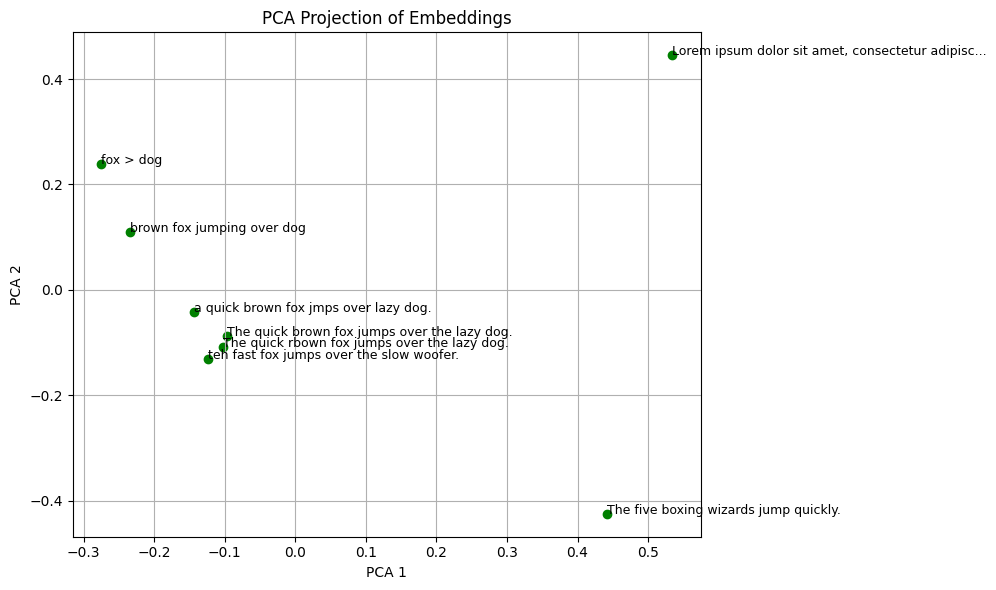

In [24]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# PCA to 2D
pca = PCA(n_components=2)
proj = pca.fit_transform(normalized_embeddings)

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(proj[:, 0], proj[:, 1], c='green')

for i, txt in enumerate(truncated_texts):
    plt.annotate(txt, (proj[i, 0], proj[i, 1]), fontsize=9)

plt.title("PCA Projection of Embeddings")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.tight_layout()
plt.show()


### Apply KMeans Clustering on the PCA embeddings

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


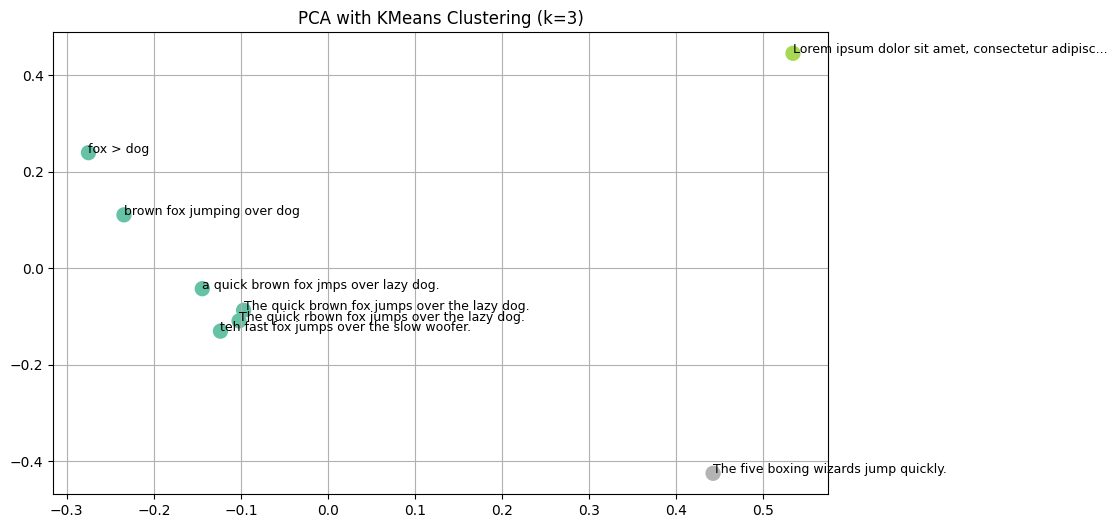

In [25]:
from sklearn.cluster import KMeans

k = 3  # adjust as needed
kmeans = KMeans(n_clusters=k, random_state=42)
labels = kmeans.fit_predict(normalized_embeddings)

# Visualize with cluster coloring
plt.figure(figsize=(10, 6))
plt.scatter(proj[:, 0], proj[:, 1], c=labels, cmap="Set2", s=100)

for i, txt in enumerate(truncated_texts):
    plt.annotate(txt, (proj[i, 0], proj[i, 1]), fontsize=9)

plt.title(f"PCA with KMeans Clustering (k={k})")
plt.grid(True)
plt.show()


### You can see the scores for a particular term directly by looking it up in the dataframe.

In [26]:
sim['The quick brown fox jumps over the lazy dog.'].sort_values(ascending=False)

The quick brown fox jumps over the lazy dog.          0.999998
The quick rbown fox jumps over the lazy dog.          0.944768
a quick brown fox jmps over lazy dog.                 0.858135
brown fox jumping over dog                            0.809306
teh fast fox jumps over the slow woofer.              0.805136
fox > dog                                             0.734423
The five boxing wizards jump quickly.                 0.663754
Lorem ipsum dolor sit amet, consectetur adipisc...    0.617958
Name: The quick brown fox jumps over the lazy dog., dtype: float64